In [0]:
import warnings                                  # do not disturbe mode
warnings.filterwarnings('ignore')

# Load packages
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions

# Importing everything from forecasting quality metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error


In [0]:
df = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/after_covid_daily.csv", parse_dates=['ds'])
df_covid = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/Covid.csv")

In [0]:
df_input = df.copy()

In [0]:
df_input['ds'] = pd.to_datetime(df_input['ds'])

In [0]:
df_activations = df_input[['ds', 'simulated']]
df_activations = df_activations.rename(columns = {'simulated':'activations'})
df_activations_index = df_activations.set_index(['ds'])
df_activations.head()

,ds,activations
0,2022-03-01 00:00:00+00:00,3007
1,2022-03-02 00:00:00+00:00,3313
2,2022-03-03 00:00:00+00:00,2827
3,2022-03-04 00:00:00+00:00,2974
4,2022-03-05 00:00:00+00:00,2914


# Smooth Data

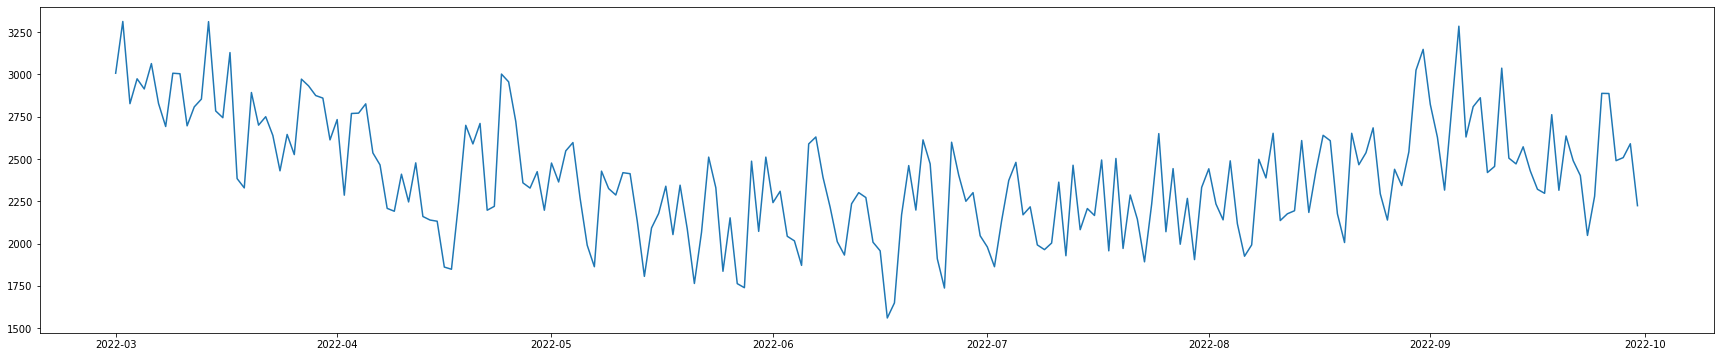

In [0]:
from statsmodels.tsa.ar_model import AutoReg

plt.figure(figsize = (30, 6))
plt.plot(df_activations_index, label = 'activations')
plt.show()

## so we saw the trend of the cost

In [0]:
def test_ts(ts, w, title='test_ts'):
    roll_mean = ts.rolling(window = w).mean()
    roll_std = ts.rolling(window = w).std()
    pd_ewma = ts.ewm(com = 0.5).mean()
    
    plt.figure(figsize = (30, 5))
    plt.clf()
    plt.grid()
    plt.plot(ts, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.plot(pd_ewma, color='yellow', label = 'EWMA')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

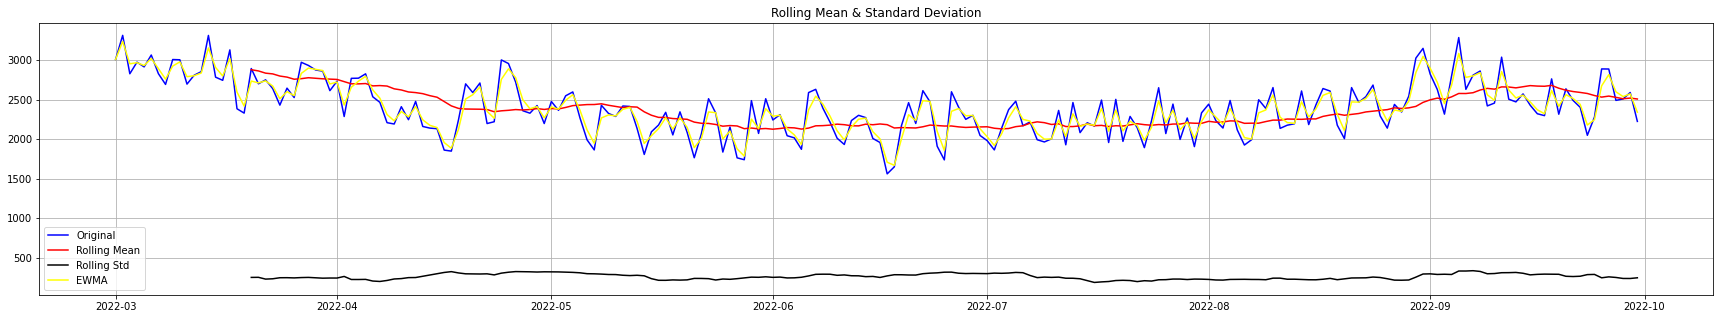

In [0]:
test_ts(df_activations_index, 20, title='test_org')

# Check Order

In [0]:
from statsmodels.tsa.stattools import adfuller

t_stat, p_value, usedlag, nobs, critical_values, resstore  = adfuller(df_activations_index, autolag='AIC')
print(f'ADF Statistic: {t_stat:.2f}')
print(f'p-value: {p_value:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'{key}, {value:.2f}')
      
      
## The data is not stationary

ADF Statistic: -2.69
p-value: 0.08
Critial Values:
1%, -3.46
Critial Values:
5%, -2.88
Critial Values:
10%, -2.57


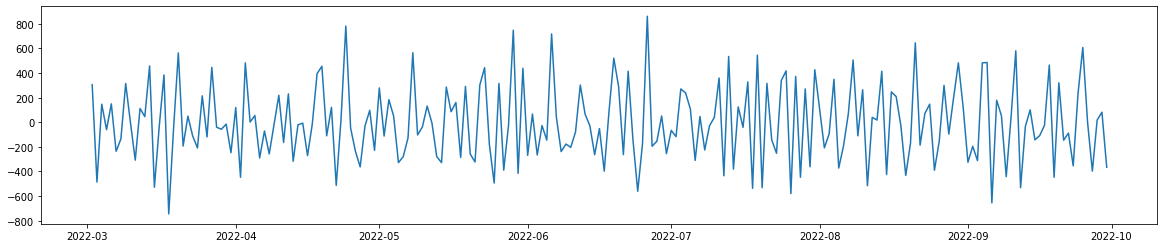

In [0]:
first_diff_cost = df_activations_index.diff()[1:]

plt.figure(figsize = (20, 4))
plt.plot(first_diff_cost, label = 'Diff #1')
plt.show()

In [0]:
from statsmodels.tsa.stattools import adfuller

t_stat, p_value, usedlag, nobs, critical_values, resstore  = adfuller(first_diff_cost, autolag='AIC')
print(f'ADF Statistic: {t_stat:.2f}')
print(f'p-value: {p_value:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'{key}, {value:.2f}')

ADF Statistic: -6.38
p-value: 0.00
Critial Values:
1%, -3.46
Critial Values:
5%, -2.88
Critial Values:
10%, -2.57


In [0]:
# second_diff_cost = first_diff_cost.diff()[1:]

# plt.figure(figsize = (20, 4))
# plt.plot(second_diff_cost, label = 'Diff #2')
# plt.show()

In [0]:
# from statsmodels.tsa.stattools import adfuller

# t_stat, p_value, usedlag, nobs, critical_values, resstore  = adfuller(second_diff_cost, autolag='AIC')
# print(f'ADF Statistic: {t_stat:.2f}')
# print(f'p-value: {p_value:.2f}')
# for key, value in critical_values.items():
#      print('Critial Values:')
#      print(f'{key}, {value:.2f}')

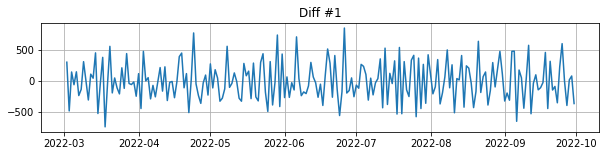

In [0]:
plt.figure(figsize=(10,2))
plt.plot(first_diff_cost)
plt.title('Diff #1')
plt.grid()
plt.show()

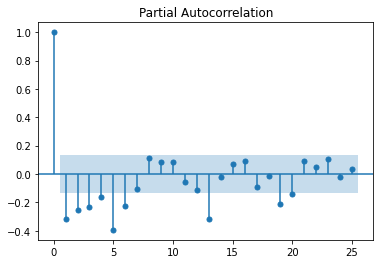

In [0]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(first_diff_cost, lags =25)
plt.show()

##AR=13 or 5

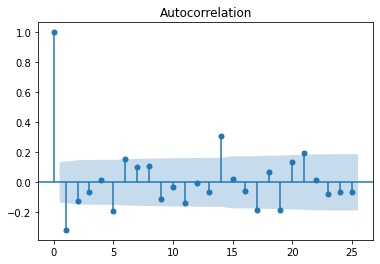

In [0]:
plot_acf(first_diff_cost, lags =25)
plt.show()

##MA=1

# Check Seasonal Order

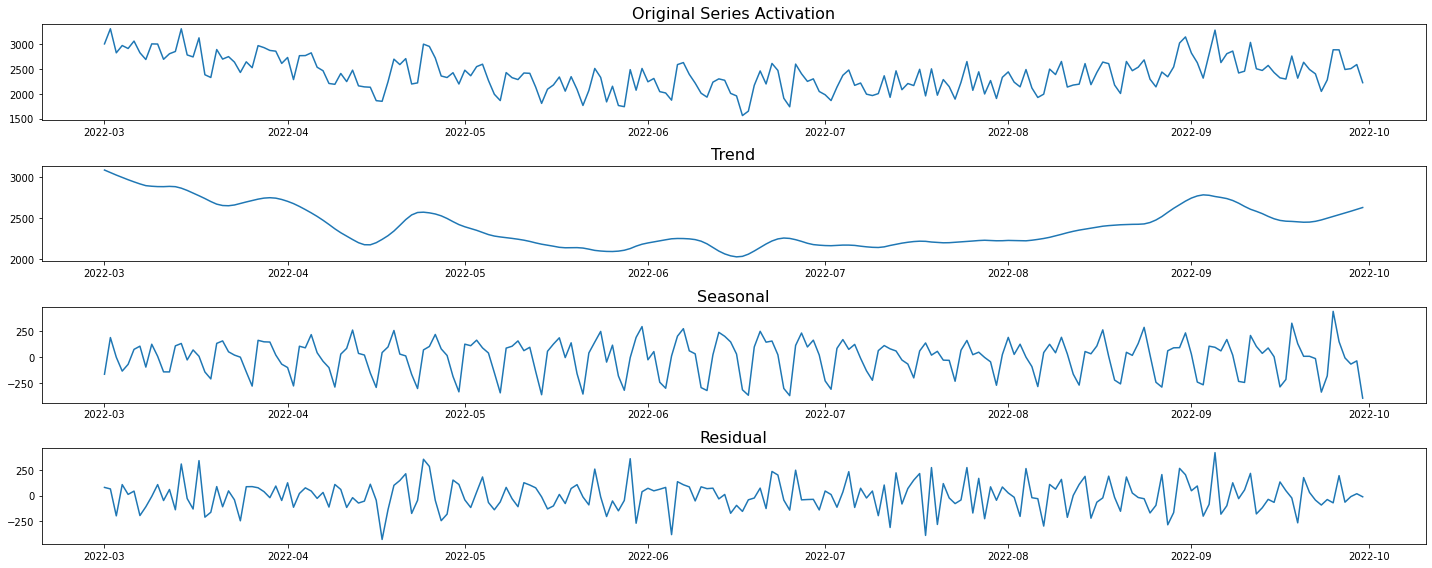

In [0]:
from statsmodels.tsa.seasonal import STL

stl_cost = STL(df_activations_index)
result_activation = stl_cost.fit()

seasonal_act, trend_act, resid_act = result_activation.seasonal, result_activation.trend, result_activation.resid

plt.figure(figsize=(20,8))


plt.subplot(4,1,1)
plt.plot(df_activations_index)
plt.title('Original Series Activation', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_act)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_act)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_act)
plt.title('Residual', fontsize=16)

plt.tight_layout()

In [0]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [0]:
check_stationarity(seasonal_act)

The series is stationary


In [0]:
from statsmodels.tsa.stattools import adfuller

t_stat, p_value, usedlag, nobs, critical_values, resstore  = adfuller(seasonal_act, autolag='AIC')
print(f'ADF Statistic: {t_stat:.2f}')
print(f'p-value: {p_value:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'{key}, {value:.2f}')
      
      
## The data not stationary

ADF Statistic: -8.30
p-value: 0.00
Critial Values:
1%, -3.46
Critial Values:
5%, -2.88
Critial Values:
10%, -2.57


In [0]:
# first_diff_cost = seasonal_act.diff()[1:]

# plt.figure(figsize = (20, 4))
# plt.plot(first_diff_cost, label = 'Diff #1')
# plt.show()

In [0]:
# from statsmodels.tsa.stattools import adfuller

# t_stat, p_value, usedlag, nobs, critical_values, resstore  = adfuller(first_diff_cost, autolag='AIC')
# print(f'ADF Statistic: {t_stat:.2f}')
# print(f'p-value: {p_value:.2f}')
# for key, value in critical_values.items():
#      print('Critial Values:')
#      print(f'{key}, {value:.2f}')

In [0]:
# second_diff_cost = first_diff_cost.diff()[1:]

# plt.figure(figsize = (20, 4))
# plt.plot(second_diff_cost, label = 'Diff #2')
# plt.show()

In [0]:
# from statsmodels.tsa.stattools import adfuller

# t_stat, p_value, usedlag, nobs, critical_values, resstore  = adfuller(second_diff_cost, autolag='AIC')
# print(f'ADF Statistic: {t_stat:.2f}')
# print(f'p-value: {p_value:.2f}')
# for key, value in critical_values.items():
#      print('Critial Values:')
#      print(f'{key}, {value:.2f}')

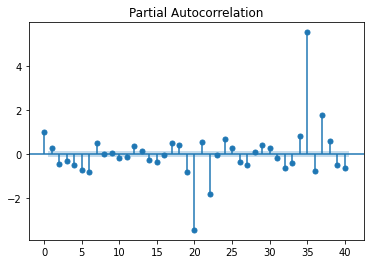

In [0]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(seasonal_act, lags =40)
plt.show()

# P could be:1

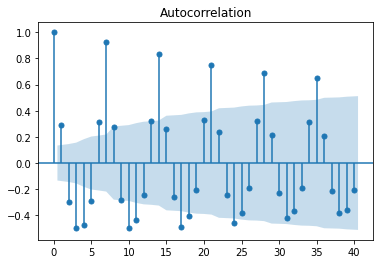

In [0]:
plot_acf(seasonal_act, lags =40)
plt.show()

# Q could be: 1

Out[27]: <AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

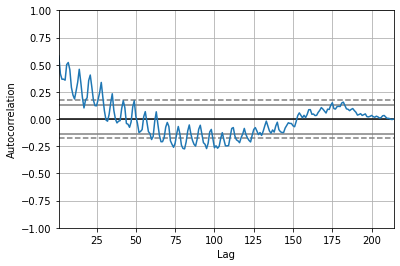

In [0]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_activations_index)

Out[28]: <AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

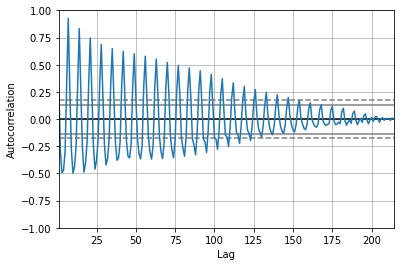

In [0]:
autocorrelation_plot(seasonal_act)

In [0]:
df_activations_index = df_activations_index.asfreq(freq='D')

train = df_activations_index.iloc[:int(len(df_activations_index)*0.9)]
validation = df_activations_index.iloc[int(len(df_activations_index)*0.9):int(len(df_activations_index)*0.95)]
test = df_activations_index.iloc[int(len(df_activations_index)*0.95):]

print("train:" + str(train.shape))
print("validation:" + str(validation.shape))
print("test:" + str(test.shape))

train:(192, 1)
validation:(11, 1)
test:(11, 1)


In [0]:
df_covid

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2020,continentExp
0,12/09/2022,12,9,2022,4915.0,1.0,Austria,AT,AUT,8901064,Europe
1,11/09/2022,11,9,2022,2730.0,1.0,Austria,AT,AUT,8901064,Europe
2,10/09/2022,10,9,2022,3399.0,3.0,Austria,AT,AUT,8901064,Europe
3,09/09/2022,9,9,2022,4139.0,2.0,Austria,AT,AUT,8901064,Europe
4,08/09/2022,8,9,2022,4278.0,2.0,Austria,AT,AUT,8901064,Europe
...,...,...,...,...,...,...,...,...,...,...,...
27621,08/02/2020,8,2,2020,0.0,0.0,Sweden,SE,SWE,10327589,Europe
27622,07/02/2020,7,2,2020,0.0,0.0,Sweden,SE,SWE,10327589,Europe
27623,06/02/2020,6,2,2020,0.0,0.0,Sweden,SE,SWE,10327589,Europe
27624,05/02/2020,5,2,2020,0.0,0.0,Sweden,SE,SWE,10327589,Europe


#MODEL BUILDING

In [0]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(5, 1, 1), ##321
                                seasonal_order=(1, 1, 7, 7) ##3117
                                )

results = mod.fit()

print(results.summary().tables[1])

/databricks/python/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7000      1.073     -1.585      0.113      -3.803       0.403
ar.L2         -1.2119      0.753     -1.609      0.108      -2.689       0.265
ar.L3         -0.7711      0.549     -1.404      0.160      -1.847       0.305
ar.L4         -0.3309      0.306     -1.081      0.280      -0.931       0.269
ar.L5         -0.0691      0.113     -0.612      0.540      -0.291       0.152
ma.L1          0.9967      1.237      0.806      0.420      -1.428       3.421
ar.S.L7       -0.9416      0.068    -13.789      0.000      -1.075      -0.808
ma.S.L7       -0.1878      0.902     -0.208      0.835      

In [0]:
train_pred = results.predict(start=train.index[0], end=train.index[int(len(train))-1], dynamic=False)
#pred_ci = pred.conf_int()

In [0]:
val_pred = results.predict(start=validation.index[0], end=validation.index[int(len(validation))-1], dynamic=False)
#pred_ci = pred.conf_int()

                 0
count   192.000000
mean     26.369140
std     337.510924
min   -1627.802192
25%    -148.127875
50%      10.277198
75%     144.002401
max    3007.000000


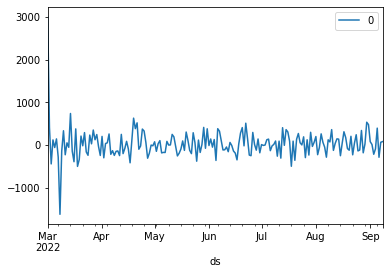

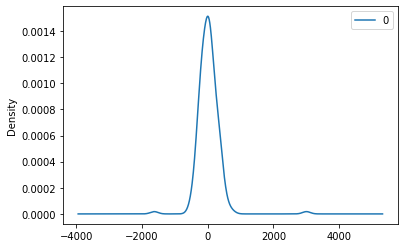

In [0]:
# line plot of residuals
residuals = pd.DataFrame(results.resid)
residuals.plot()
# density plot of residuals
residuals.plot(kind='kde')
# summary stats of residuals
print(residuals.describe())

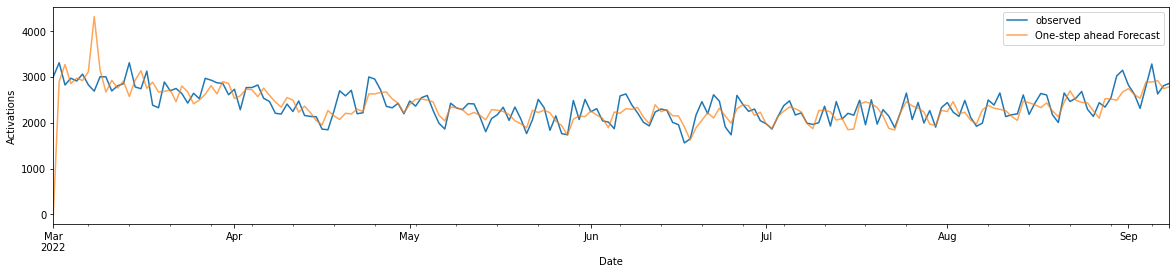

In [0]:
plt.figure(figsize = (20, 4))

ax = train['activations'].plot(label='observed')
train_pred.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Activations')
plt.legend()


plt.show()

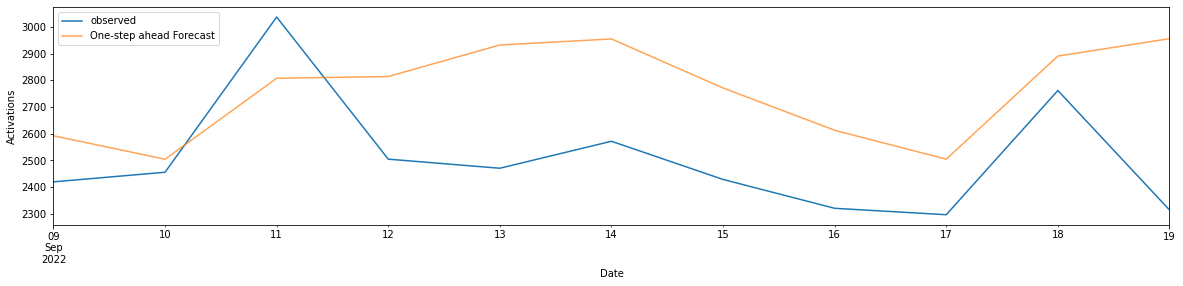

In [0]:
plt.figure(figsize = (20, 4))

ax = validation['activations'].plot(label='observed')
val_pred.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Activations')
plt.legend()


plt.show()

In [0]:
y_forecasted = train_pred
y_truth = train

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score, mean_squared_error

print("MAPE: " + str(mean_absolute_percentage_error(y_truth, y_forecasted)))
print("r2: " + str(r2_score(y_truth, y_forecasted)))
print("RMSE: " + str(mean_squared_error(y_truth, y_forecasted, squared=False)))

MAPE: 0.08501539077825591
r2: 0.07995174400028482
RMSE: 337.6620426693028


In [0]:
y_forecasted = val_pred
y_truth = validation

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score, mean_squared_error

print("MAPE: " + str(mean_absolute_percentage_error(y_truth, y_forecasted)))
print("r2: " + str(r2_score(y_truth, y_forecasted)))
print("RMSE: " + str(mean_squared_error(y_truth, y_forecasted, squared=False)))

MAPE: 0.11878664317750029
r2: -1.5105081869595947
RMSE: 332.1039845193279


#TEST

In [0]:
train_validation = df_activations_index.iloc[:len(train) + len(validation)]
train_validation = train_validation.asfreq(freq='D')

print("train_validation:" + str(train_validation.shape))

train_validation:(203, 1)


In [0]:
mod = sm.tsa.statespace.SARIMAX(train_validation,
                                order=(5, 1, 1), 
                                seasonal_order=(1, 1, 7, 7))

results_test = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7000      1.073     -1.585      0.113      -3.803       0.403
ar.L2         -1.2119      0.753     -1.609      0.108      -2.689       0.265
ar.L3         -0.7711      0.549     -1.404      0.160      -1.847       0.305
ar.L4         -0.3309      0.306     -1.081      0.280      -0.931       0.269
ar.L5         -0.0691      0.113     -0.612      0.540      -0.291       0.152
ma.L1          0.9967      1.237      0.806      0.420      -1.428       3.421
ar.S.L7       -0.9416      0.068    -13.789      0.000      -1.075      -0.808
ma.S.L7       -0.1878      0.902     -0.208      0.835      -1.957       1.581
ma.S.L14      -0.8618      0.305     -2.823      0.005      -1.460      -0.263
ma.S.L21       0.1333      0.182      0.734      0.463      -0.223       0.489
ma.S.L28      -0.0032      0.122     -0.026      0.9

In [0]:
test_pred = results_test.predict(start=test.index[0], end=test.index[int(len(test))-1], dynamic=False)

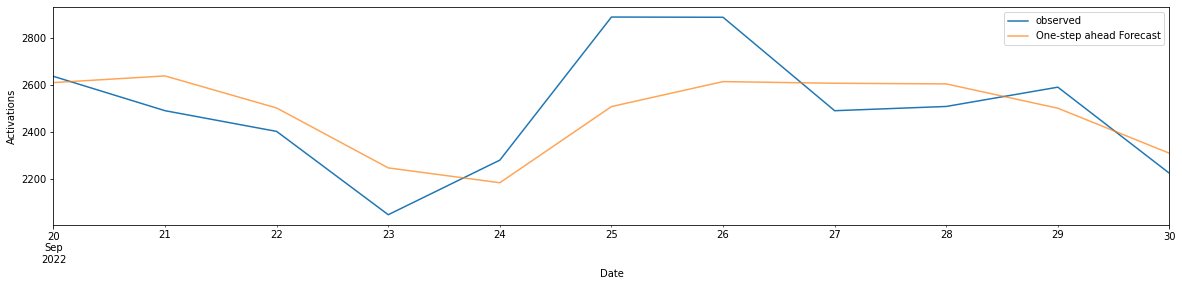

In [0]:
plt.figure(figsize = (20, 4))

ax = test['activations'].plot(label='observed')
test_pred.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Activations')
plt.legend()


plt.show()

In [0]:
y_forecasted = test_pred
y_truth = test

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score, mean_squared_error

print("MAPE: " + str(mean_absolute_percentage_error(y_truth, y_forecasted)))
print("r2: " + str(r2_score(y_truth, y_forecasted)))
print("RMSE: " + str(mean_squared_error(y_truth, y_forecasted, squared=False)))

MAPE: 0.0576813766889701
r2: 0.49077016633001813
RMSE: 175.50498449690343


In [0]:
full_pre = train_pred.append([val_pred, test_pred]).to_frame(name='forecasted_activations')
full_pre.index.name = 'ds'
full_pre

,forecasted_activations
ds,
2022-03-01 00:00:00+00:00,0.000000
2022-03-02 00:00:00+00:00,2903.439634
2022-03-03 00:00:00+00:00,3273.113603
2022-03-04 00:00:00+00:00,2857.298224
2022-03-05 00:00:00+00:00,2975.547129
...,...
2022-09-26 00:00:00+00:00,2613.635535
2022-09-27 00:00:00+00:00,2606.649676
2022-09-28 00:00:00+00:00,2603.871493


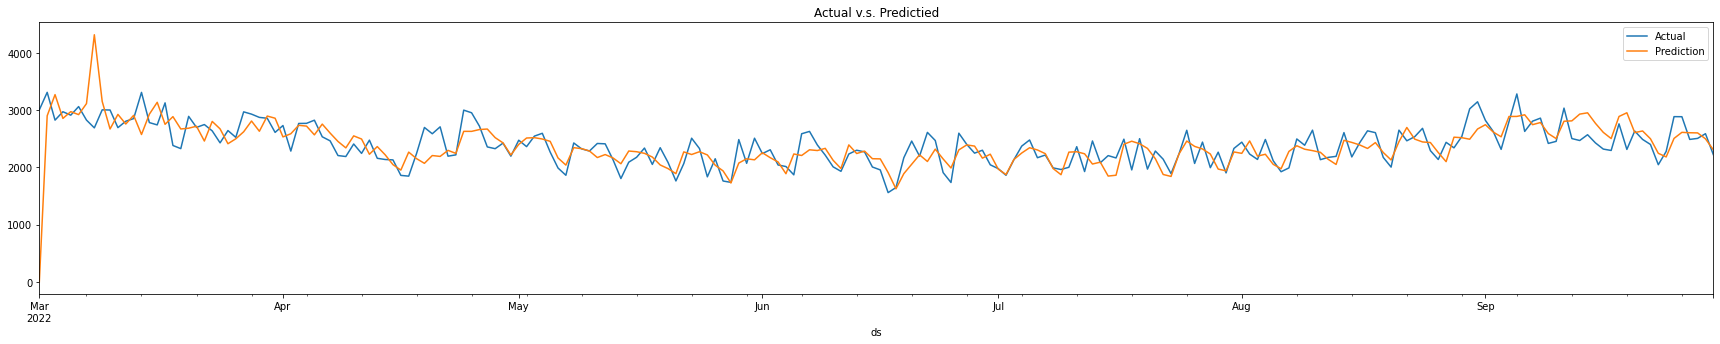

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

df_activations.plot(kind='line',x='ds', y='activations', label='Actual', ax=ax)
full_pre.reset_index().plot(kind='line',x='ds', y='forecasted_activations', label='Prediction', ax=ax)
plt.title('Actual v.s. Predictied')
plt.legend()
plt.show()

# FORECASTING

In [0]:
mod = sm.tsa.statespace.SARIMAX(df_activations_index,
                                order=(5, 1, 1), 
                                seasonal_order=(1, 1, 7, 7))

results = mod.fit()

print(results.summary().tables[1])

/databricks/python/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2969      0.278     -1.066      0.286      -0.843       0.249
ar.L2         -0.2835      0.202     -1.405      0.160      -0.679       0.112
ar.L3         -0.1693      0.170     -0.997      0.319      -0.502       0.164
ar.L4         -0.0695      0.119     -0.584      0.559      -0.303       0.164
ar.L5         -0.1463      0.089     -1.642      0.101      -0.321       0.028
ma.L1         -0.4083      0.282     -1.448      0.148      -0.961       0.144
ar.S.L7       -0.9965      0.052    -19.029      0.000      -1.099      -0.894
ma.S.L7       -0.1644      0.580     -0.284      0.777      

In [0]:
pred_fc = results.get_forecast(steps = 92, dynamic=True)

In [0]:
prediction = {
  'activations' : pred_fc.predicted_mean
}

prediction_df = pd.DataFrame(prediction)
prediction_df.head()

,activations
2022-10-01 00:00:00+00:00,2181.285802
2022-10-02 00:00:00+00:00,2545.783460
2022-10-03 00:00:00+00:00,2588.225317
2022-10-04 00:00:00+00:00,2557.545180
2022-10-05 00:00:00+00:00,2590.034424


<Figure size 1440x288 with 0 Axes>

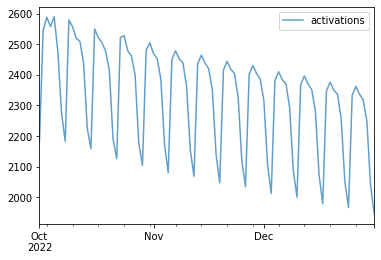

In [0]:
plt.figure(figsize = (20, 4))

prediction_df.plot(label='One-step ahead Forecast', alpha=.7)

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Activations')
plt.legend()


plt.show()

In [0]:
prediction_df = prediction_df.reset_index()
prediction_df.columns = ['ds', 'activations']
prediction_df = prediction_df[['ds', 'activations']]
prediction_df.head(5)

,ds,activations
0,2022-10-01 00:00:00+00:00,2181.285802
1,2022-10-02 00:00:00+00:00,2545.783460
2,2022-10-03 00:00:00+00:00,2588.225317
3,2022-10-04 00:00:00+00:00,2557.545180
4,2022-10-05 00:00:00+00:00,2590.034424


#Do

In [0]:
future_real = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/D_Input_new.csv", parse_dates=['ds'])
future_real = future_real[['ds', 'simulated']]
future_real.head()

,ds,simulated
0,2022-09-01 00:00:00+00:00,3234
1,2022-09-02 00:00:00+00:00,2801
2,2022-09-03 00:00:00+00:00,2642
3,2022-09-04 00:00:00+00:00,2884
4,2022-09-05 00:00:00+00:00,3115


In [0]:
future_real_df = future_real[future_real['ds'] >= '2022-10-01']
future_real_df_index = future_real_df.set_index(['ds'])
future_real_df_index.head()

,simulated
ds,
2022-10-01 00:00:00+00:00,2370
2022-10-02 00:00:00+00:00,2355
2022-10-03 00:00:00+00:00,3068
2022-10-04 00:00:00+00:00,2640
2022-10-05 00:00:00+00:00,2602


In [0]:
prediction_df = prediction_df[prediction_df['ds'] >= '2022-10-01']
prediction_df = prediction_df[prediction_df['ds'] < '2022-11-27'].set_index(['ds'])
prediction_df.tail(5)

,activations
ds,
2022-11-22 00:00:00+00:00,2418.284349
2022-11-23 00:00:00+00:00,2404.771173
2022-11-24 00:00:00+00:00,2327.147993
2022-11-25 00:00:00+00:00,2120.885584
2022-11-26 00:00:00+00:00,2034.554527


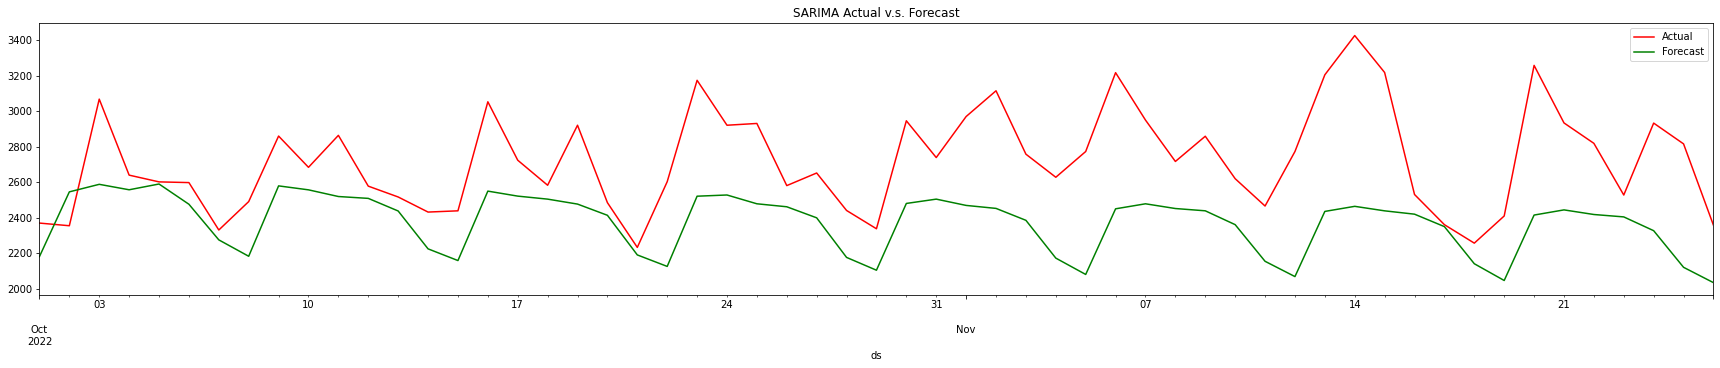

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

future_real_df_index.plot(kind='line',y='simulated', color='red', label='Actual', ax=ax)
prediction_df.plot(kind='line',y='activations', color='green',label='Forecast', ax=ax)
plt.title('SARIMA Actual v.s. Forecast')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import mean_absolute_percentage_error,  r2_score, mean_squared_error

y_true = future_real_df_index
y_pred = prediction_df

print('mape:', mean_absolute_percentage_error(y_true, y_pred))
print('r2:', r2_score(y_true, y_pred))
print('RMSE', mean_squared_error(y_true, y_pred, squared=False))

mape: 0.12441523186303921
r2: -1.250750958037707
RMSE 426.15136123118003
